# Stock Option Pricing and Analysis

This Jupyter Notebook allows users to analyze and price stock options using two popular methods:
1. **Black-Scholes Model** for theoretical price calculation.
2. **Monte Carlo Simulation** for estimated pricing.

Additionally, it calculates **Implied Volatility**, which is crucial for understanding whether an option is overvalued or undervalued in the market. Also, it plots the **Implied Volatility** for either call or put options.

## Prerequisites

Before running this notebook, ensure that you have the following Python packages installed:

- `numpy`: For numerical operations.
- `yfinance`: For fetching stock and options data from Yahoo Finance.
- `scipy`: For optimization and statistical functions.
- `datetime`: For handling date and time operations.
- `matplotlib`: For ploting the chart.

## Author

**Ehsan Jafari  
12/08/2024**


In [1]:
import numpy as np
import yfinance as yf
from scipy.stats import norm
from scipy.optimize import minimize
import datetime
import matplotlib.pyplot as plt

## Function Definitions

The following functions will be defined to perform various calculations related to stock options, including fetching option data, calculating Black-Scholes prices, determining implied volatility, and performing Monte Carlo simulations.

In [9]:
def get_option_data(option_ticker):
    # Extract the stock ticker from the option ticker
    stock_ticker = option_ticker[:4]  # Example: AAPL from AAPL241220C00255000
    print(stock_ticker)
    option_type = option_ticker[10]     # 'C' for Call, 'P' for Put
    expiration_str = option_ticker[4:10] # Expiration date in YYMMDD format
    strike_price_str = option_ticker[12:]  # Extract everything after the option type for the strike price

    # Convert strike price to float (e.g., '00255000' -> 255.00)
    strike_price = int(strike_price_str) / 1000.0

    # Convert expiration string to a datetime object
    expiration_date = datetime.datetime.strptime(expiration_str, "%y%m%d").date()

    # Fetch stock data
    stock = yf.Ticker(stock_ticker)
    stock_data = stock.history(period='1d')
    underlying_price = stock_data['Close'].iloc[-1]
    
    # Fetch the latest interest rate from IRX (iShares U.S. Treasury Bond ETF)
    irx_data = yf.Ticker("^IRX")
    
    dividend_yield = stock.info.get('trailingAnnualDividendYield', 0)

    # Get the last interest rate
    last_interest_rate = irx_data.info['previousClose']
    risk_free_rate = last_interest_rate/100

    
    # Convert expiration_date to the correct format string
    expiration_date_str = expiration_date.strftime('%Y-%m-%d')

    # Fetch option data
    options = stock.option_chain(expiration_date_str)
    option_df = options.calls if option_type == 'C' else options.puts
    option_row = option_df[option_df['strike'] == strike_price]

    if option_row.empty:
        raise ValueError("Option not found in Yahoo Finance data.")

    option_price = option_row['lastPrice'].values[0]

    print(f"Underlying Price: {underlying_price:.2f}")
    print(f"Strike Price: {strike_price}")
    print(f"Expiration Date: {expiration_date}")
    print(f"Option Type: {option_type}")
    print(f"Risk-Free Rate: {risk_free_rate*100:.2f}%")
    print(f"Option Price: {option_price}")
    print(f"Dividend Yield: {dividend_yield*100:.2f}%")
    
    return underlying_price, strike_price, expiration_date, option_type, risk_free_rate, option_price, stock_ticker, dividend_yield

### Black-Scholes Pricing Function with Dividend Yield

The **Black-Scholes model** is a mathematical model for pricing an options contract. It provides a theoretical estimate of the price of European-style options. In cases where the underlying asset pays dividends, the model can be adjusted to include the continuous dividend yield. The key inputs to the model now include:

- **S**: Current price of the underlying asset (stock price).
- **K**: Strike price of the option.
- **T**: Time to expiration in years (expiration date - current date).
- **r**: Risk-free interest rate (annualized).
- **σ**: Volatility of the underlying asset (standard deviation of the asset's returns).
- **q**: Continuous dividend yield (annualized).

The Black-Scholes formula for a Call option (C) and Put option (P) considering the dividend yield is given by:

- **Call option price (C)**:
  
  $C = S e^{-qT} N(d_1) - K e^{-rT} N(d_2)$

- **Put option price (P)**:

  $P = K e^{-rT} N(-d_2) - S e^{-qT} N(-d_1)$

Where:

$d_1 = \frac{\ln(S/K) + (r - q + 0.5\sigma^2)T}{\sigma\sqrt{T}}$

$d_2 = d_1 - \sigma\sqrt{T}$

Here, $N(d)$ is the cumulative distribution function of the standard normal distribution.


In [10]:
def black_scholes_price(underlying_price, strike_price, time_to_maturity, risk_free_rate, volatility, option_type, dividend_yield):
    if option_type == 'C':
        d1 = (np.log(underlying_price / strike_price) + (risk_free_rate - dividend_yield + 0.5 * volatility ** 2) * time_to_maturity) / (volatility * np.sqrt(time_to_maturity))
        d2 = d1 - volatility * np.sqrt(time_to_maturity)
        call_price = (underlying_price * np.exp(-dividend_yield * time_to_maturity) * norm.cdf(d1) - strike_price * np.exp(-risk_free_rate * time_to_maturity) * norm.cdf(d2))
        return call_price
    elif option_type == 'P':
        d1 = (np.log(underlying_price / strike_price) + (risk_free_rate - dividend_yield + 0.5 * volatility ** 2) * time_to_maturity) / (volatility * np.sqrt(time_to_maturity))
        d2 = d1 - volatility * np.sqrt(time_to_maturity)
        put_price = (strike_price * np.exp(-risk_free_rate * time_to_maturity) * norm.cdf(-d2) - underlying_price * np.exp(-dividend_yield * time_to_maturity) * norm.cdf(-d1))
        return put_price

### Implied Volatility Calculation

**Implied Volatility (IV)** is a metric that reflects the market's forecast of a likely movement in a security's price. It is derived from the market price of an option and indicates the expected future volatility of the underlying asset.

The calculation involves finding the volatility value that makes the theoretical Black-Scholes option price equal to the market price of the option. This is achieved using numerical optimization techniques.

The objective function for implied volatility is defined as:

$
\text{Objective} = \left( C_{BS} - C_{Market} \right)^2
$

Where:
- $C_{BS}$ = Black-Scholes price calculated with the guessed volatility.
- $C_{Market}$ = Actual market price of the option.


In [11]:
def implied_volatility(option_price, underlying_price, strike_price, time_to_maturity, risk_free_rate, option_type, dividend_yield):
    def objective_function(volatility):
        return (black_scholes_price(underlying_price, strike_price, time_to_maturity, risk_free_rate, volatility, option_type, dividend_yield) - option_price) ** 2
    
    result = minimize(objective_function, 0.2, bounds=[(0.01, 5)])
    return result.x[0]

### Monte Carlo Simulation

**Monte Carlo Simulation** is a computational algorithm that relies on repeated random sampling to obtain numerical results. In the context of options pricing, it is used to simulate the future price paths of the underlying asset.

The basic steps for the Monte Carlo simulation for option pricing are:
1. Simulate multiple potential future prices of the underlying asset using a geometric Brownian motion model.
2. Calculate the payoff for each simulated price.
3. Discount the average payoff back to present value

In [12]:
def monte_carlo_option_price(underlying_price, strike_price, time_to_maturity, risk_free_rate, volatility, option_type, dividen_yield, num_simulations=10000):
    np.random.seed(0)
    payoffs = []
    
    for _ in range(num_simulations):
        # Simulate the end price using a random normal variable
        z = np.random.standard_normal()
        stock_price_at_expiration = underlying_price * np.exp((risk_free_rate - dividend_yield - 0.5 * volatility**2) * time_to_maturity + volatility * np.sqrt(time_to_maturity) * z)
        
        # Calculate the payoff
        if option_type == "C":
            payoffs.append(max(stock_price_at_expiration - strike_price, 0))
        else:  # option_type == "P"
            payoffs.append(max(strike_price - stock_price_at_expiration, 0))
    
    # Calculate the Monte Carlo price
    option_price = np.exp((-risk_free_rate + dividend_yield) * time_to_maturity) * np.mean(payoffs)
    return option_price

In [17]:
option_ticker = input("Enter the stock option ticker (e.g., AAPL241220C00255000): ")

# Get option and underlying stock data
underlying_price, strike_price, expiration_date, option_type, risk_free_rate, option_price, stock_ticker, dividend_yield = get_option_data(option_ticker)

# Calculate time to maturity in years
today = datetime.date.today()
time_to_maturity = (expiration_date - today).days / 365.0

# Calculate implied volatility
iv = implied_volatility(option_price, underlying_price, strike_price, time_to_maturity, risk_free_rate, option_type, dividend_yield)
print(f"Calculated Implied Volatility: {iv:.2%}")

# Price the option using Monte Carlo simulation
monte_carlo_price = monte_carlo_option_price(underlying_price, strike_price, time_to_maturity, risk_free_rate, iv, option_type, dividend_yield)
print(f"\nMonte Carlo Price: {monte_carlo_price:.2f}")

# Determine if the option is underpriced or overpriced
if option_price < monte_carlo_price:
    print("**The option is underpriced.**")
else:
    print("**The option is overpriced.**")

Enter the stock option ticker (e.g., AAPL241220C00255000): AAPL241220C00255000
AAPL
Underlying Price: 221.27
Strike Price: 255.0
Expiration Date: 2024-12-20
Option Type: C
Risk-Free Rate: 5.07%
Option Price: 2.74
Dividend Yield: 0.45%
Calculated Implied Volatility: 21.94%

Monte Carlo Price: 2.60
**The option is overpriced.**


### Volatility Smile Plot

The plot generated by the `plot_volatility_smile` function displays the relationship between strike prices and implied volatility for the specified options. Here's how to interpret the plot:

- **X-Axis (Strike Price)**: Represents the different strike prices of the options. The position of the strike price relative to the current price of the underlying asset can significantly influence the implied volatility.
  
- **Y-Axis (Implied Volatility)**: Represents the implied volatility, which reflects the market's expectations for future volatility of the underlying asset. 

- **Scatter Points**: Each point on the graph represents an option with a specific strike price and its corresponding implied volatility.

- **Trends**: 
  - If the plot shows higher implied volatility for out-of-the-money options (both calls and puts), it often indicates market sentiment expecting larger price movements (greater uncertainty).
  - Conversely, a lower implied volatility for at-the-money options may suggest a more stable outlook.

By analyzing the volatility smile, traders can gain insights into market conditions and sentiment, which can inform their trading strategies.

This concludes the notebook on stock option pricing and analysis. You can now run the entire notebook to analyze stock options and visualize the volatility smile for your selected options.


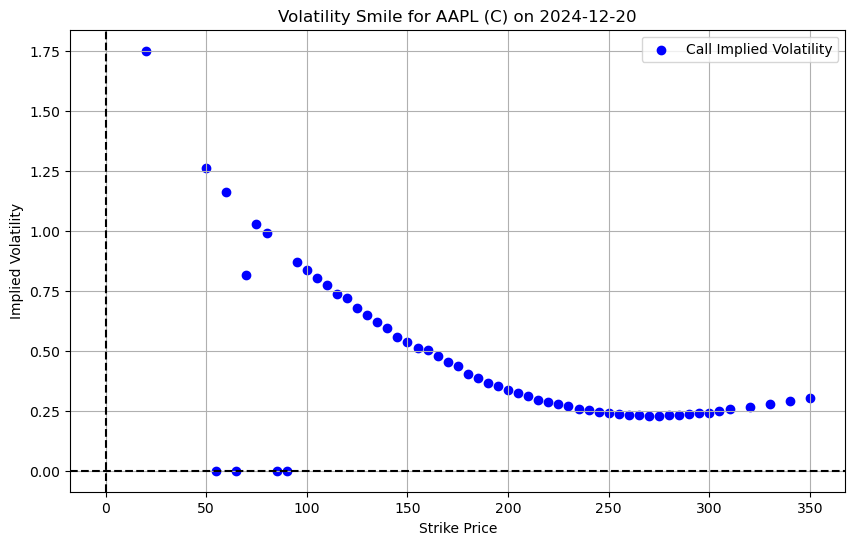

In [16]:
def plot_volatility_smile(stock_ticker, expiration_date, option_type):
    # Fetch the option chain data
    stock = yf.Ticker(stock_ticker)


    # Attempt to fetch the option chain
    try:
        options = stock.option_chain(expiration_date)
    except Exception as e:
        print(f"Error fetching option chain for {expiration_date}: {e}")
        return

    # Determine whether to plot calls or puts based on user input
    if option_type.lower() == 'c':
        data = options.calls
        label = 'Call Implied Volatility'
    elif option_type.lower() == 'p':
        data = options.puts
        label = 'Put Implied Volatility'
    else:
        print("Invalid option type. Please enter 'call' or 'put'.")
        return

    # Extract strike prices and implied volatilities
    strike_prices = data['strike'].tolist()
    implied_vols = data['impliedVolatility'].tolist()

    # Remove None values for volatility
    strike_prices = [s for s, iv in zip(strike_prices, implied_vols) if iv is not None]
    implied_vols = [iv for iv in implied_vols if iv is not None]

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.scatter(strike_prices, implied_vols, color='blue', label=label)
    plt.title(f'Volatility Smile for {stock_ticker} ({option_type.capitalize()}) on {expiration_date}')
    plt.xlabel('Strike Price')
    plt.ylabel('Implied Volatility')
    plt.axhline(y=0, color='black', linestyle='--')
    plt.axvline(x=0, color='black', linestyle='--')
    plt.legend()
    plt.grid()
    plt.show()
    

expiration_date_str = expiration_date.strftime('%Y-%m-%d')
plot_volatility_smile(stock_ticker, expiration_date_str, option_type)